Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import time
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
pd.options.mode.chained_assignment = None  # default='warn'

In [82]:
#import the dataset

data = pd.read_csv('/datasets/car_data.csv')

#general information

data.info()

#get a sample

data.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


We should determine what columns are needed for training our model.

The **target** will be the **Price** column.

However, a few of the columns do not seem fit for using as features, including:

- `'DateCrawled'` are just dates of recording the information.
- `'Price'` will be our target
- `'DateCreated'` similar to datecrawled
- `'LastSeen'` should not impact our model
- `'PostalCode'` not very useful in terms of training our model
- `'NumberOfPictures'` not relevant to the training

We will proceed with the rest of the feature columns and see if we can improve them. 

- `'vehicle type'` categorical, but there are some missing values, we can fill in 'unknown' instead of NaN.
- `'RegistrationYear'` continuous interval. Should be okay.
- `'Gearbox'` categorical, some missing values, we can fill in 'unknown'.
- `'Power'` numerical.
- `'Model'` categorical. We can fill in 'unknown'.
- `'Mileage'` numerical.
- `'Registrationmonth'` categorical.
- `'Fueltype'` categorical, can fill in 'unknown' if needed.
- `'Brand'` categorical. 
- `'NotRepaired'` categorical. can fill in 'unknown' if needed.

Let's go through each and preprocess our data. 



### Data Preprocessing

In [83]:
#dropping unnecessary columns.

data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis = 1)

In [84]:
#check column in RegistrationYear

data['RegistrationYear'].value_counts()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

We see some years that do not make sense, let's remove those. 

In [85]:
#save only registrations between certain years
data = data[(data['RegistrationYear'] >= 1940) & (data['RegistrationYear'] <= 2021)]

data.shape[0]

354042

Since there are missing values in 'Price', 'Power', 'RegistrationMonth', we want to first make sure that no 0s are included.

In [86]:
#include data that are not zeros

data = data[data['Price'] != 0]
data = data[data['Power'] != 0]
data = data[data['RegistrationMonth'] != 0]

data.shape[0]

287080

In [87]:
# fill rest of NAs with 'unknown', luckily, they are all categorical, so unknown will suffice.

data = data.fillna('Unknown')


In [88]:
# check duplicates & drop them

data.drop_duplicates(inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264236 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              264236 non-null  int64 
 1   VehicleType        264236 non-null  object
 2   RegistrationYear   264236 non-null  int64 
 3   Gearbox            264236 non-null  object
 4   Power              264236 non-null  int64 
 5   Model              264236 non-null  object
 6   Mileage            264236 non-null  int64 
 7   RegistrationMonth  264236 non-null  int64 
 8   FuelType           264236 non-null  object
 9   Brand              264236 non-null  object
 10  NotRepaired        264236 non-null  object
dtypes: int64(5), object(6)
memory usage: 24.2+ MB


I think our data should be clean now. Let's move on to split the dataset & encode them.

We will be training Linear Regression, Decision Tree Regressor, Random Forest Regressor, CatBoost Regressor, and LightGBM. Since CatBoost Regressor and LightGBM has their own encoder, we will make a copy of the clean dataset. One without encoding for Catboost and LightGBM, and one after one hot encoder(OHE) for Linear Regression, Decision Tree Regressor, Random Forest Regressor, since they require encoding the categorical columns.

In [89]:
# make a copy for ohe & apply ohe & split

categorical = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired']

data_ohe = data.copy()
data_ohe = pd.get_dummies(data = data_ohe, columns = categorical, drop_first = True)

features = data_ohe.drop(['Price'], axis = 1)
target = data_ohe['Price']

f_train_ohe, f_test_ohe, t_train_ohe, t_test_ohe = train_test_split(features, target, test_size = 0.25, random_state = 12345)

print(f_train_ohe.shape,
     f_test_ohe.shape,
     t_train_ohe.shape,
     t_test_ohe.shape)


(198177, 321) (66059, 321) (198177,) (66059,)


In [90]:
#split the dataset for catboost and lightgbm

features_g = data.drop(['Price'], axis = 1)
target_g = data['Price']

f_train_gbm, f_test_gbm, t_train_gbm, t_test_gbm = train_test_split(features_g, target_g, test_size = 0.25, random_state = 12345)

print(f_train_gbm.shape,
     f_test_gbm.shape,
     t_train_gbm.shape,
     t_test_gbm.shape)

(198177, 10) (66059, 10) (198177,) (66059,)


Now we will scale our dataset.


In [91]:
#scale the numerical columns

numericals = ['RegistrationYear', 'Power', 'Mileage']

scaler = StandardScaler()
scaler.fit(f_train_ohe[numericals])

f_train_gbm[numericals] = scaler.transform(f_train_gbm[numericals])
f_test_gbm[numericals] = scaler.transform(f_test_gbm[numericals])

f_train_ohe[numericals] = scaler.transform(f_train_ohe[numericals])
f_test_ohe[numericals] = scaler.transform(f_test_ohe[numericals])


## Model training

In [92]:
#make a table to store results for easy comparsion

model_results = pd.DataFrame(columns = ('model', 'process_time', 'score_time', 'RMSE'))
model_results.head()

,model,process_time,score_time,RMSE


In [93]:
#create a function for RMSE for easier processing

def rmse (y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    rmse_score = mse**0.5
    return  rmse_score

rmse_score = make_scorer(rmse, greater_is_better=False) 


### Linear Regression

In [94]:
#create our linear regression model

model_lr = LinearRegression()

lr_data = ['Linear Regression']

start = time.time()
model_lr.fit(f_train_ohe, t_train_ohe)
end = time.time()

lr_data.append(end-start)

start = time.time()
prediction = model_lr.predict(f_test_ohe)
end=time.time()

lr_data.append(end-start)

lr_rmse = rmse(t_test_ohe, prediction)
lr_data.append(lr_rmse)

model_results.loc[len(model_results)] = lr_data
model_results.head()


,model,process_time,score_time,RMSE
0,Linear Regression,13.457295,0.195968,2783.650858


We will use the RMSE from LinearRegression as a baseline value, let's see if other models preform better. 

### Decision Tree

In [95]:
#create our decision tree model and tune hyperparameter

for depth in range (1, 11):
    model_dt = DecisionTreeRegressor(max_depth = depth, random_state = 12345)
    model_score_dt = cross_val_score(model_dt, f_train_ohe, t_train_ohe, scoring = rmse_score, cv = 5)
    print('Max_depth of', depth, 'score:', model_score_dt.mean())

Max_depth of 1 score: -3780.49490273557
Max_depth of 2 score: -3298.8319096961764
Max_depth of 3 score: -3023.7021809883563
Max_depth of 4 score: -2715.4795503484543
Max_depth of 5 score: -2502.626965921495
Max_depth of 6 score: -2343.2297259554393
Max_depth of 7 score: -2225.211613076525
Max_depth of 8 score: -2143.606677463726
Max_depth of 9 score: -2081.6281462491997
Max_depth of 10 score: -2040.2316144056472


Since with max_depth of 10, we get the best score, let's use 10.

In [96]:
#create our decision tree model

model_dt = DecisionTreeRegressor(max_depth = 10, random_state = 12345)

dt_data = ['Decision Tree']

start = time.time()
model_dt.fit(f_train_ohe, t_train_ohe)
end = time.time()

dt_data.append(end-start)

start = time.time()
prediction = model_dt.predict(f_test_ohe)
end=time.time()

dt_data.append(end-start)

dt_rmse = rmse(t_test_ohe, prediction)
dt_data.append(dt_rmse)

model_results.loc[len(model_results)] = dt_data
model_results.head()


,model,process_time,score_time,RMSE
0,Linear Regression,13.457295,0.195968,2783.650858
1,Decision Tree,2.964767,0.096797,2016.086753


We got better RMSE than linear regression.

### Random Forest

In [97]:
#create our random forest model and tune hyperparameter

for n in range (10, 51, 10):
    model_rf = RandomForestRegressor(max_depth = 10, random_state = 12345, n_estimators = n)
    model_score_rf = cross_val_score(model_rf, f_train_ohe, t_train_ohe, scoring = rmse_score, cv = 5)
    print('n_estimators of', n, 'score:', model_score_rf.mean())

n_estimators of 10 score: -1936.2330909982472
n_estimators of 20 score: -1928.618300092988
n_estimators of 30 score: -1926.1948464244647
n_estimators of 40 score: -1924.690601584287
n_estimators of 50 score: -1923.9415610755968


n_estimator = 50 seemed to work the best.

In [98]:
#create our random forest model

model_rf = RandomForestRegressor(max_depth = 10, random_state = 12345, n_estimators = 50)

rf_data = ['Random Forest']

start = time.time()
model_rf.fit(f_train_ohe, t_train_ohe)
end = time.time()

rf_data.append(end-start)

start = time.time()
prediction = model_rf.predict(f_test_ohe)
end=time.time()

rf_data.append(end-start)

rf_rmse = rmse(t_test_ohe, prediction)
rf_data.append(rf_rmse)

model_results.loc[len(model_results)] = rf_data
model_results.head()


,model,process_time,score_time,RMSE
0,Linear Regression,13.457295,0.195968,2783.650858
1,Decision Tree,2.964767,0.096797,2016.086753
2,Random Forest,91.451110,0.337605,1921.895720


Randomforest seemed to work the best right now

### CatBoost

In [99]:
#CatBoost and hyperparameter tuning
model_cb = CatBoostRegressor()
parameters = {'depth': [6, 8, 10],
           'learning_rate': [0.5, 0.1],
           'l2_leaf_reg': [2, 4],
           'iterations': [10, 20],
           'loss_function': ['RMSE'],
           'random_seed': [12345]
            }
grid=GridSearchCV(estimator=model_cb, param_grid=parameters, scoring=rmse_score, cv=3, n_jobs=-1, verbose=10)
grid.fit(f_train_gbm, t_train_gbm, cat_features=categorical)
best_param=grid.best_params_
best_score = grid.best_score_

print('best_score =', best_score)
print('best_parameters =', best_param)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START depth=6, iterations=10, l2_leaf_reg=2, learning_rate=0.5, loss_function=RMSE, random_seed=12345
0:	learn: 3348.1982629	total: 66.1ms	remaining: 595ms
1:	learn: 2704.6954743	total: 121ms	remaining: 484ms
2:	learn: 2434.1315483	total: 186ms	remaining: 434ms
3:	learn: 2241.3696967	total: 248ms	remaining: 372ms
4:	learn: 2144.9293445	total: 300ms	remaining: 300ms
5:	learn: 2083.0817067	total: 352ms	remaining: 235ms
6:	learn: 2021.5343418	total: 405ms	remaining: 174ms
7:	learn: 1988.6326933	total: 460ms	remaining: 115ms
8:	learn: 1965.8382778	total: 515ms	remaining: 57.2ms
9:	learn: 1946.1796530	total: 571ms	remaining: 0us
[CV 1/3; 1/24] END depth=6, iterations=10, l2_leaf_reg=2, learning_rate=0.5, loss_function=RMSE, random_seed=12345; total time=   1.4s
[CV 2/3; 1/24] START depth=6, iterations=10, l2_leaf_reg=2, learning_rate=0.5, loss_function=RMSE, random_seed=12345
0:	learn: 3347.4891112	total: 66.4ms	rem

In [100]:
#to run on our model
model_cb=CatBoostRegressor(depth = best_param['depth'],
                     iterations = best_param['iterations'],
                     l2_leaf_reg = best_param['l2_leaf_reg'],
                     learning_rate = best_param['learning_rate'],
                     loss_function = 'RMSE', random_seed = 12345)

cb_data = ['CatBoost']

start = time.time()
model_cb = model_cb.fit(f_train_gbm, t_train_gbm, cat_features=categorical, verbose=False, plot=False)
end = time.time()

cb_data.append(end-start)

start = time.time()
cb_predict = model_cb.predict(f_test_gbm)
end = time.time()

cb_data.append(end-start)

cb_rmse = rmse(t_test_gbm, cb_predict)

cb_data.append(cb_rmse)

model_results.loc[len(model_results)] = cb_data
model_results.head()

,model,process_time,score_time,RMSE
0,Linear Regression,13.457295,0.195968,2783.650858
1,Decision Tree,2.964767,0.096797,2016.086753
2,Random Forest,91.451110,0.337605,1921.895720
3,CatBoost,3.245389,0.087541,1726.178533


Catboost is doing very well. 

### LightGBM

In [101]:
#convert all categorical variables to 'category'

for columns in categorical:
    f_train_gbm[columns] = f_train_gbm[columns].astype('category')
    f_test_gbm[columns] = f_test_gbm[columns].astype('category')

In [102]:
#hyperparameter tuning

model_lgbm=LGBMRegressor()
parameters={'num_leaves': [10, 20, 30],
           'learning_rate': [0.5, 0.1],
           'n_estimators': [10, 20],
           'random_state': [123456],
           'objective': ['rmse']}
grid=GridSearchCV(estimator=model_lgbm, param_grid=parameters, scoring=rmse_score, cv=3, n_jobs=-1)
grid.fit(f_train_gbm, t_train_gbm)
best_param = grid.best_params_
best_score = grid.best_score_

print('best_score =', best_score)
print('best_parameters =', best_param)

best_score = -1731.2271498656994
best_parameters = {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'objective': 'rmse', 'random_state': 123456}


In [103]:
#to run on our model

model_lgbm = LGBMRegressor(learning_rate = best_param['learning_rate'],
                  n_estimators = best_param['n_estimators'],
                  num_leaves = best_param['num_leaves'],
                  objective = 'rmse', random_state = 12345)

lgbm_data = ['LightGBM']

start = time.time()
model_lgbm = model_lgbm.fit(f_train_gbm, t_train_gbm)
end = time.time()

lgbm_data.append(end-start)

start = time.time()
lgbm_predict = model_lgbm.predict(f_test_gbm)
end = time.time()

lgbm_data.append(end-start)

lgbm_rmse = rmse(t_test_gbm, lgbm_predict)

lgbm_data.append(lgbm_rmse)

model_results.loc[len(model_results)] = lgbm_data
model_results.head()

,model,process_time,score_time,RMSE
0,Linear Regression,13.457295,0.195968,2783.650858
1,Decision Tree,2.964767,0.096797,2016.086753
2,Random Forest,91.451110,0.337605,1921.895720
3,CatBoost,3.245389,0.087541,1726.178533
4,LightGBM,1.490608,0.200216,1724.159892


RMSE better than baseline and slightly better than Catboost

## Model analysis

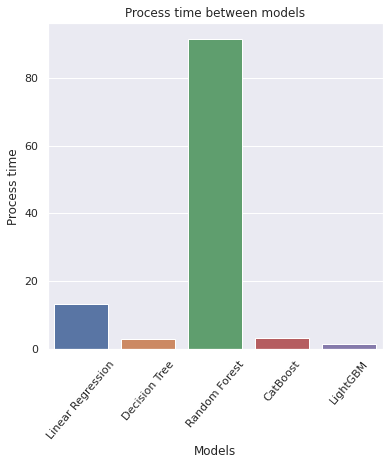

In [113]:
# let's compare
#process time
ax = sns.barplot(x='model', y='process_time', data = model_results)
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=50)
sns.set(rc={'figure.figsize':(6,6)})
ax.set(xlabel='Models', ylabel='Process time', title = 'Process time between models')
plt.show()

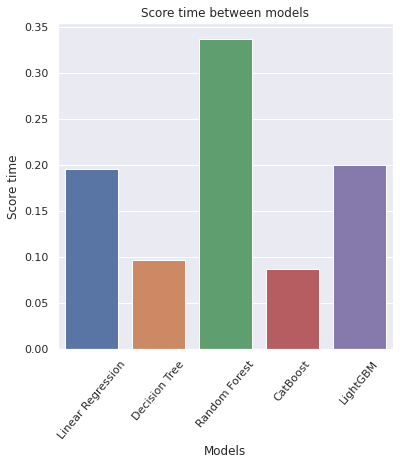

In [112]:
#score time
ax = sns.barplot(x='model', y='score_time', data = model_results)
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=50)
sns.set(rc={'figure.figsize':(6,6)})
ax.set(xlabel='Models', ylabel='Score time', title = 'Score time between models')
plt.show()

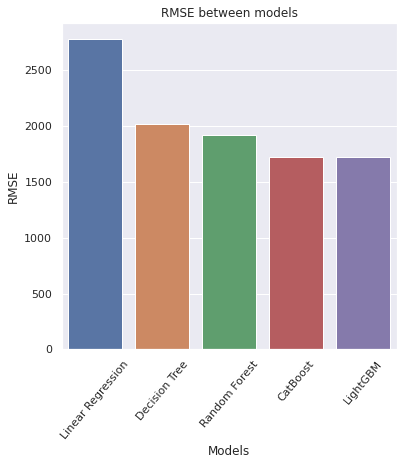

In [114]:
#RMSE 
ax = sns.barplot(x='model', y='RMSE', data = model_results)
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=50)
sns.set(rc={'figure.figsize':(6,6)})
ax.set(xlabel='Models', ylabel='RMSE', title = 'RMSE between models')
plt.show()

# Conclusion

In Linear Regression, Decision Tree, and Random Forest:

we can see that decision tree takes the least amount of time to compute, while random forest has the best RMSE. 

Between Catboost and LightGBM, both performed similarly well, with low computing time and low RMSE. 

Overall, Gradient boost methods outperformed traditional regression methods. 